# Implementación Deep Q-Network 

Este notebook implementa un DQN, un algoritmo de q-learning aproximado con experience replay y target networks. Entrena el algoritmo en el openAI's gym para el juego breakout de Atari y monitorea las partidas exportando videos.



In [1]:
#Imports necesarios
import gym
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Procesando la imagen del juego 

Las imágenes de atari sin procesar son grandes, 210x160x3 por defecto. Sin embargo, no es necesario ese nivel de detalle para aprender de ellos.

Por lo tanto, podemos ahorrar mucho tiempo procesando previamente la imagen del juego, incluyend
* Cambiar el tamaño a uno más pequeño, 64 x 64
* Convertirlo a escala de grises
* Recortar partes irrelevantes de la imagen (top & bottom)

In [2]:
from gym.core import ObservationWrapper
from gym.spaces import Box

# from scipy.misc import imresize
import cv2

class PreprocessAtari(ObservationWrapper):
    def __init__(self, env):
        """A gym wrapper that crops, scales image into the desired shapes and optionally grayscales it."""
        ObservationWrapper.__init__(self,env)

        self.img_size = (84, 84)
        self.observation_space = Box(0.0, 1.0, (self.img_size[0], self.img_size[1], 1))

    def observation(self, img):
        """what happens to each observation"""

        # crop image (top and bottom, top from 34, bottom remove last 16)
        img = img[34:-16, :, :]

        # resize image
        img = cv2.resize(img, self.img_size)

        img = img.mean(-1,keepdims=True)

        img = img.astype('float32') / 255.

        return img


### Frame buffer

Nuestro agente solo puede procesar una observación a la vez, por lo que debemos asegurarnos de que contenga suficiente información para encontrar acciones óptimas. Por ejemplo, el agente tiene que reaccionar a los objetos en movimiento, por lo que debe poder medir la velocidad del objeto.
Para ello, introducimos un búfer que almacena 4 últimas imágenes.

In [3]:
from gym.spaces.box import Box
from gym.core import Wrapper

class FrameBuffer(Wrapper):
    def __init__(self, env, n_frames=4, dim_order='tensorflow'):
        """A gym wrapper that reshapes, crops and scales image into the desired shapes"""
        super(FrameBuffer, self).__init__(env)
        self.dim_order = dim_order
        if dim_order == 'tensorflow':
            height, width, n_channels = env.observation_space.shape
            """Multiply channels dimension by number of frames"""
            obs_shape = [height, width, n_channels * n_frames]
        else:
            raise ValueError('dim_order should be "tensorflow" or "pytorch", got {}'.format(dim_order))
        self.observation_space = Box(0.0, 1.0, obs_shape)
        self.framebuffer = np.zeros(obs_shape, 'float32')

    def reset(self):
        """resets breakout, returns initial frames"""
        self.framebuffer = np.zeros_like(self.framebuffer)
        self.update_buffer(self.env.reset())
        return self.framebuffer

    def step(self, action):
        """plays breakout for 1 step, returns frame buffer"""
        new_img, reward, done, info = self.env.step(action)
        self.update_buffer(new_img)
        return self.framebuffer, reward, done, info

    def update_buffer(self, img):
        if self.dim_order == 'tensorflow':
            offset = self.env.observation_space.shape[-1]
            axis = -1
            cropped_framebuffer = self.framebuffer[:,:,:-offset]
        self.framebuffer = np.concatenate([img, cropped_framebuffer], axis = axis)


In [4]:

def make_env():
    env = gym.make("BreakoutDeterministic-v4")
    env = PreprocessAtari(env)
    env = FrameBuffer(env, n_frames=4, dim_order='tensorflow')
    return env

#Instatntiate gym Atari-Breakout environment
env = make_env()
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

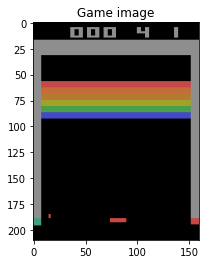

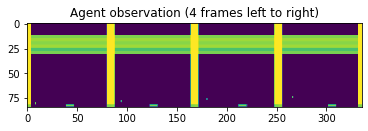

In [5]:
# review Atari image, and actual observation of the Agent after processing
for _ in range(50):
    obs, _, _, _ = env.step(env.action_space.sample())


plt.title("Game image")
plt.imshow(env.render("rgb_array"))
plt.show()
plt.title("Agent observation (4 frames left to right)")
plt.imshow(obs.transpose([0,2,1]).reshape([state_dim[0],-1]));

### Construyendo una red

Ahora necesitamos construir una red neuronal que pueda mapear imágenes para indicar q-values. Esta red se llamará en cada paso del agente.

In [6]:
#Import TensorFlow and Keras
import tensorflow as tf
import tensorflow.compat.v1 as tf

import keras
from keras.layers import Conv2D, Dense, Flatten, InputLayer
tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()
sess = tf.compat.v1.InteractiveSession()



In [7]:
from keras.layers import Conv2D, Dense, Flatten
class DQNAgent:
    def __init__(self, name, state_shape, n_actions, epsilon=0, reuse=False):
        """A simple DQN agent"""
        with tf.compat.v1.variable_scope(name, reuse=reuse):

            self.network = keras.models.Sequential()

            # Keras ignores the first dimension in the input_shape, which is the batch size.
            # So just use state_shape for the input shape
            self.network.add(Conv2D(32, (8, 8), strides=4, activation='relu',use_bias=False, input_shape=state_shape,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (4, 4), strides=2, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(64, (3, 3), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
            self.network.add(Conv2D(1024, (7, 7), strides=1, activation='relu',use_bias=False,kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))
            self.network.add(Flatten())
            self.network.add(Dense(n_actions, activation='linear',kernel_initializer=tf.compat.v1.variance_scaling_initializer(scale=2)))

            # prepare a graph for agent step
            self.state_t = tf.compat.v1.placeholder('float32', [None,] + list(state_shape))
            self.qvalues_t = self.get_symbolic_qvalues(self.state_t)

        self.weights = tf.compat.v1.get_collection(tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=name)
        self.epsilon = epsilon

    def get_symbolic_qvalues(self, state_t):
        """takes agent's observation, returns qvalues. Both are tf Tensors"""
        qvalues = self.network(state_t)


        assert tf.debugging.is_numeric_tensor(qvalues) and qvalues.shape.ndims == 2, \
            "please return 2d tf tensor of qvalues [you got %s]" % repr(qvalues)
        assert int(qvalues.shape[1]) == n_actions

        return qvalues

    def get_qvalues(self, state_t):
        """Same as symbolic step except it operates on numpy arrays"""
        sess = tf.compat.v1.get_default_session()
        return sess.run(self.qvalues_t, {self.state_t: state_t})

    def sample_actions(self, qvalues):
        """pick actions given qvalues. Uses epsilon-greedy exploration strategy. """
        epsilon = self.epsilon
        batch_size, n_actions = qvalues.shape
        random_actions = np.random.choice(n_actions, size=batch_size)
        best_actions = qvalues.argmax(axis=-1)
        should_explore = np.random.choice([0, 1], batch_size, p = [1-epsilon, epsilon])
        return np.where(should_explore, random_actions, best_actions)

In [8]:
agent = DQNAgent("dqn_agent", state_dim, n_actions, epsilon=0.5)
sess.run(tf.global_variables_initializer())

In [9]:
#Evaluate agents performance, in a number of games
def evaluate(env, agent, n_games=1, greedy=False, t_max=10000):
    """ Plays n_games full games. If greedy, picks actions as argmax(qvalues). Returns mean reward. """
    rewards = []
    s = env.reset()
    for _ in range(n_games):
        reward = 0
        for _ in range(t_max):
            qvalues = agent.get_qvalues([s])
            action = qvalues.argmax(axis=-1)[0] if greedy else agent.sample_actions(qvalues)[0]
            s, r, done, _ = env.step(action)
         
            reward += r
            if done: 
              s = env.reset()
              break
          
        
        rewards.append(reward)
    return np.mean(rewards)

### Experience replay
#### La interfaz es bastante simple:
* `exp_replay.add(obs, act, rw, next_obs, done)` - guarda la tupla(s,a,r,s',done) en el bufer.
* `exp_replay.sample(batch_size)` - devuelve observations, actions, rewards, next_observations y is_done para muestras aleatorias de  `batch_size`.
* `len(exp_replay)` - devuelve el número de elementos almacenados en  el replay buffer.

In [10]:
import random

class ReplayBuffer(object):
    def __init__(self, size):
        """Create Replay buffer.
        Parameters
        ----------
        size: int
            Max number of transitions to store in the buffer. When the buffer
            overflows the old memories are dropped.
        """
        self._storage = []
        self._maxsize = size
        self._next_idx = 0

    def __len__(self):
        return len(self._storage)

    def add(self, obs_t, action, reward, obs_tp1, done):
        data = (obs_t, action, reward, obs_tp1, done)

        if self._next_idx >= len(self._storage):
            self._storage.append(data)
        else:
            self._storage[self._next_idx] = data
        self._next_idx = (self._next_idx + 1) % self._maxsize

    def _encode_sample(self, idxes):
        obses_t, actions, rewards, obses_tp1, dones = [], [], [], [], []
        for i in idxes:
            data = self._storage[i]
            obs_t, action, reward, obs_tp1, done = data
            obses_t.append(np.array(obs_t, copy=False))
            actions.append(np.array(action, copy=False))
            rewards.append(reward)
            obses_tp1.append(np.array(obs_tp1, copy=False))
            dones.append(done)
        return np.array(obses_t), np.array(actions), np.array(rewards), np.array(obses_tp1), np.array(dones)

    def sample(self, batch_size):
        """Sample a batch of experiences.
        Parameters
        ----------
        batch_size: int
            How many transitions to sample.
        Returns
        -------
        obs_batch: np.array
            batch of observations
        act_batch: np.array
            batch of actions executed given obs_batch
        rew_batch: np.array
            rewards received as results of executing act_batch
        next_obs_batch: np.array
            next set of observations seen after executing act_batch
        done_mask: np.array
            done_mask[i] = 1 if executing act_batch[i] resulted in
            the end of an episode and 0 otherwise.
        """
        idxes = [random.randint(0, len(self._storage) - 1) for _ in range(batch_size)]
        return self._encode_sample(idxes)


In [11]:
def play_and_record(agent, env, exp_replay, n_steps=1):
    """
    Play the game for exactly n steps, record every (s,a,r,s', done) to replay buffer. 
    Whenever game ends, add record with done=True and reset the game.
    :returns: return sum of rewards over time
    
    Note: please do not env.reset() unless env is done.
    It is guaranteed that env has done=False when passed to this function.
    """
    # State at the beginning of rollout
    s = env.framebuffer
    
    # Play the game for n_steps as per instructions above
    reward = 0.0
    for t in range(n_steps):
        # get agent to pick action given state s
        qvalues = agent.get_qvalues([s])
        action = agent.sample_actions(qvalues)[0]
        next_s, r, done, _ = env.step(action)
        
        # add to replay buffer
        exp_replay.add(s, action, r, next_s, done)
        reward += r
        if done:
            s = env.reset()
        else:
            s = next_s
    return reward
        
    

### Target networks

También empleamos la llamada "target network", una copia de los pesos de la red neuronal que se utilizará para los Q-values de referencia:

La red en sí es una copia exacta de la red del agente, pero sus parámetros no están entrenados. En cambio, se mueven aquí desde la red actual del agente de vez en cuando.

$$ Q_{reference}(s,a) = r + \gamma \cdot \max _{a'} Q_{target}(s',a') $$




In [12]:
target_network = DQNAgent("target_network", state_dim, n_actions)

In [13]:
def load_weigths_into_target_network(agent, target_network):
    """ assign target_network.weights variables to their respective agent.weights values. """
    assigns = []
    for w_agent, w_target in zip(agent.weights, target_network.weights):
        assigns.append(tf.assign(w_target, w_agent, validate_shape=True))
    tf.get_default_session().run(assigns)
    


### Aprendiendo con... Q-learning
Aquí escribimos una función similar a `agent.update` de tabular q-learning.

In [14]:
# Create placeholders that will be fed with exp_replay.sample(batch_size)
obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
actions_ph = tf.placeholder(tf.int32, shape=[None])
rewards_ph = tf.placeholder(tf.float32, shape=[None])
next_obs_ph = tf.placeholder(tf.float32, shape=(None,) + state_dim)
is_done_ph = tf.placeholder(tf.float32, shape=[None])

is_not_done = 1 - is_done_ph
gamma = 0.99

Tomar los q-values para las acciones que acaba de realizar el agente

In [15]:
current_qvalues = agent.get_symbolic_qvalues(obs_ph)
current_action_qvalues = tf.reduce_sum(tf.one_hot(actions_ph, n_actions) * current_qvalues, axis=1)

Calcular el error de TD Q-learning :

$$ L = { 1 \over N} \sum_i [ Q_{\theta}(s,a) - Q_{reference}(s,a) ] ^2 $$

Con Q-reference  definida como

$$ Q_{reference}(s,a) = r(s,a) + \gamma \cdot max_{a'} Q_{target}(s', a') $$

Donde
* $Q_{target}(s',a')$ denota el q-value del siguiente estado y la siguiente acción previsto por __target_network__
* $s, a, r, s'$ son los current state, action, reward y el next state respectivamente
* $\gamma$ es un factor de descuento definido dos celdas arriba.

In [16]:
# compute q-values for NEXT states with target network
next_qvalues_target =  target_network.get_symbolic_qvalues(next_obs_ph)

# compute state values by taking max over next_qvalues_target for all actions
next_state_values_target = tf.reduce_max(next_qvalues_target, axis=-1)

# compute Q_reference(s,a) as per formula above.
reference_qvalues = rewards_ph + gamma*next_state_values_target*is_not_done

# Define loss function for sgd.
# td_loss = (current_action_qvalues - reference_qvalues) ** 2
td_loss = tf.reduce_mean(tf.losses.huber_loss(labels=reference_qvalues, predictions=current_action_qvalues))

optimizer=tf.train.AdamOptimizer(1e-5)
train_step = optimizer.minimize(td_loss, var_list=agent.weights)

sess.run(tf.global_variables_initializer())

### Loop principal

Es hora de poner todo junto y ver si aprende algo.

In [17]:
#Uncomment to load stored weights of trained agent.
#agent.network.load_weights('dqn_model_atari_weights.h5')

In [18]:
#Create the buffer and fill it.
exp_replay = ReplayBuffer(70000)
play_and_record(agent, env, exp_replay, n_steps=10000)

# take a sample batch of observations from the buffer
def sample_batch(exp_replay, batch_size):
    obs_batch, act_batch, reward_batch, next_obs_batch, is_done_batch = exp_replay.sample(batch_size)
    return {
        obs_ph:obs_batch, actions_ph:act_batch, rewards_ph:reward_batch, 
        next_obs_ph:next_obs_batch, is_done_ph:is_done_batch
    }

In [19]:
from tqdm import trange
from IPython.display import clear_output
import matplotlib.pyplot as plt
from pandas import DataFrame
moving_average = lambda x, span, **kw: DataFrame({'x':np.asarray(x)}).x.ewm(span=span, **kw).mean().values
%matplotlib inline

mean_rw_history = []
td_loss_history = []

buffer size = 70000, epsilon = 0.81865


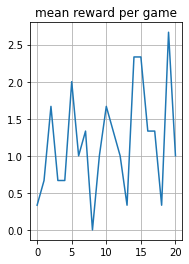

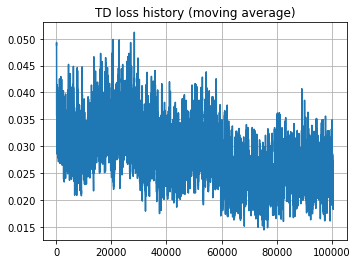

100%|██████████| 100000/100000 [58:31<00:00, 28.48it/s]


In [29]:
##Train the agent, configure the starting epsilon to one to encourage exploration
agent.epsilon=1
for i in trange(100000):
    
    # play
    play_and_record(agent, env, exp_replay, 10)
    
    # train the network
    _, loss_t = sess.run([train_step, td_loss], sample_batch(exp_replay, batch_size=64))
    td_loss_history.append(loss_t)
    
    # adjust agent parameters
    if i % 500 == 0:
        load_weigths_into_target_network(agent, target_network)
        # reduce epsilon in every iteration until it reaches 1%
        agent.epsilon = max(agent.epsilon * 0.999, 0.01)

    
    if i % 5000 == 0:
      #uncomment to store agent's weights every some iterations
#         agent.network.save_weights('/dqn_model_atari_weights.h5')
        mean_rw_history.append(evaluate(make_env(), agent, n_games=3))
        
    if i % 500 == 0:
        # plot mean reward per game and TD loss history
        clear_output(True)
        print("buffer size = %i, epsilon = %.5f" % (len(exp_replay), agent.epsilon))
        
        plt.subplot(1,2,1)
        plt.title("mean reward per game")
        plt.plot(mean_rw_history)
        plt.grid()

        assert not np.isnan(loss_t)
        plt.figure(figsize=[12, 4])
        plt.subplot(1,2,2)
        plt.title("TD loss history (moving average)")
        plt.plot(moving_average(np.array(td_loss_history), span=100, min_periods=100))
        plt.grid()
        plt.show()

        

__ Cómo interpretar los plots: __


Esto no es un aprendizaje supervisado, así que no se espera que nada mejore de manera monótona.
* __ TD loss __ es el MSE(Mean Squared Error) entre los Q-values actuales del agente y los Q-Values del objetivo. Puede aumentar o disminuir lentamente.
* __ mean reward__ es la suma esperada de r (s, a) el agente obtiene la sesión completa del juego. Oscilará, pero en promedio debería aumentar con el tiempo (después de algunos miles de iteraciones ...). 
 * En la implementación básica de q-learning, se necesitan entre 5 y 10 mil pasos para "calentar" al agente antes de que comience a mejorar.
* __ buffer size__ - Debe subir y llegar al tamaño máximo.
* __ epsilon__ - voluntad del agente para explorar. Si se ve que el epsilon del agente es 0.01 antes que la mean reward es por encima de 0 - __significa que necesita aumentar epsilon__. Se volvera a ajustar entre 0,2 y 0,5 y se reducira el ritmo al que baje.
* Se deben ignorar los primeros 100-200 pasos de cada gráfico; son solo oscilaciones debido a la forma en que funciona el promedio móvil.


__El entrenamiento llevará tiempo .__ Una estimación optimista es decir que comenzará a ganar (mean_reward> 10) después de 10k pasos

### Video

In [26]:

# Don't forget to reset epsilon back to previous value if you want to go on training
agent.epsilon=0


In [28]:
#record session on a video
import gym.wrappers
#configure directory to store videos
env_monitor = gym.wrappers.Monitor(make_env(),directory="videos",force=True)

#load stored weights of trained agent.
!wget --no-check-certificate \
    https://github.com/JordiRomeroUB/DQN-Atari-BreakOut/blob/main/dqn_model_atari_weights.h5?raw=true \
    -O /tmp/dqn_model_atari_weights.h5
agent.network.load_weights('/tmp/dqn_model_atari_weights.h5')

sessions = [evaluate(env_monitor, agent, n_games=1) for _ in range(1)]
env_monitor.close()

--2020-12-19 09:07:30--  https://github.com/JordiRomeroUB/DQN-Atari-BreakOut/blob/main/dqn_model_atari_weights.h5?raw=true
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/JordiRomeroUB/DQN-Atari-BreakOut/raw/main/dqn_model_atari_weights.h5 [following]
--2020-12-19 09:07:30--  https://github.com/JordiRomeroUB/DQN-Atari-BreakOut/raw/main/dqn_model_atari_weights.h5
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/JordiRomeroUB/DQN-Atari-BreakOut/main/dqn_model_atari_weights.h5 [following]
--2020-12-19 09:07:31--  https://raw.githubusercontent.com/JordiRomeroUB/DQN-Atari-BreakOut/main/dqn_model_atari_weights.h5
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githu

In [24]:
#view a stored video of a trained agent
%%HTML
<video "640" height="480" controls>
  <source src="https://raw.githubusercontent.com/JordiRomeroUB/DQN-Atari-BreakOut/master/trained-agent-game.mp4" type="video/mp4">
</video>